<a href="https://colab.research.google.com/github/Sucheta97/Gen-AI-GAN/blob/main/Capstone_GAN_based_Image_Generation_using_fashion_mnist_using_Vanilla_GAN_and_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)


# **Fashion-MNIST Data Loading**

In [2]:
(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = (x_train - 0.5) / 0.5      # [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # (N, 28, 28, 1)

batch_size = 128

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

for xb in train_ds.take(1):
    print("Batch:", xb.shape, "min/max:", xb.numpy().min(), xb.numpy().max())


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Batch: (128, 28, 28, 1) min/max: -1.0 1.0


# **Vanilla GAN (MLP-based)**

In [3]:
latent_dim = 100

def build_vanilla_generator(latent_dim=100):
    model = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(256),
        layers.ReLU(),
        layers.Dense(512),
        layers.ReLU(),
        layers.Dense(784, activation="tanh"),
        layers.Reshape((28, 28, 1))
    ])
    return model


In [4]:
def build_vanilla_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dense(1)  # logits
    ])
    return model


In [5]:
generator = build_vanilla_generator(latent_dim)
discriminator = build_vanilla_discriminator()

g_optimizer = keras.optimizers.Adam(1e-4)
d_optimizer = keras.optimizers.Adam(1e-4)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)


In [6]:
@tf.function
def train_vanilla_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal((batch_size, latent_dim))

    with tf.GradientTape() as d_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        d_loss_real = loss_fn(tf.ones_like(real_logits), real_logits)
        d_loss_fake = loss_fn(tf.zeros_like(fake_logits), fake_logits)
        d_loss = d_loss_real + d_loss_fake

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        fake_logits = discriminator(fake_images, training=True)
        g_loss = loss_fn(tf.ones_like(fake_logits), fake_logits)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


In [7]:
epochs = 30

for epoch in range(epochs):
    for real_images in train_ds:
        d_loss, g_loss = train_vanilla_step(real_images)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


Epoch 1/30 | D Loss: 0.0840 | G Loss: 5.3307
Epoch 2/30 | D Loss: 0.0319 | G Loss: 5.5596
Epoch 3/30 | D Loss: 0.0142 | G Loss: 5.8689
Epoch 4/30 | D Loss: 0.0663 | G Loss: 5.0713
Epoch 5/30 | D Loss: 0.0199 | G Loss: 6.2175
Epoch 6/30 | D Loss: 0.1151 | G Loss: 5.9198
Epoch 7/30 | D Loss: 0.0682 | G Loss: 4.8506
Epoch 8/30 | D Loss: 0.0469 | G Loss: 5.2740
Epoch 9/30 | D Loss: 0.0726 | G Loss: 4.9568
Epoch 10/30 | D Loss: 0.1752 | G Loss: 3.9735
Epoch 11/30 | D Loss: 0.2498 | G Loss: 5.4384
Epoch 12/30 | D Loss: 0.1110 | G Loss: 4.1266
Epoch 13/30 | D Loss: 0.1731 | G Loss: 5.3473
Epoch 14/30 | D Loss: 0.1666 | G Loss: 5.1208
Epoch 15/30 | D Loss: 0.1276 | G Loss: 4.8510
Epoch 16/30 | D Loss: 0.2044 | G Loss: 5.0902
Epoch 17/30 | D Loss: 0.1360 | G Loss: 4.4623
Epoch 18/30 | D Loss: 0.3063 | G Loss: 4.5905
Epoch 19/30 | D Loss: 0.1247 | G Loss: 4.7997
Epoch 20/30 | D Loss: 0.1955 | G Loss: 5.2525
Epoch 21/30 | D Loss: 0.2618 | G Loss: 4.9742
Epoch 22/30 | D Loss: 0.1623 | G Loss: 3.75

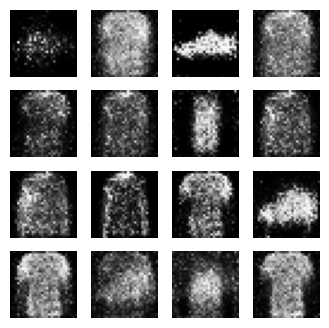

In [8]:
def show_images(generator, n=16):
    noise = tf.random.normal((n, latent_dim))
    images = generator(noise, training=False)

    images = (images + 1) / 2.0

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i,:,:,0], cmap="gray")
        plt.axis("off")
    plt.show()

show_images(generator)


# **DCGAN (Convolutional GAN)**

In [10]:
def build_dcgan_generator():
    model = keras.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(7*7*256),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2D(1, 3, padding="same", activation="tanh")
    ])
    return model


In [11]:
def build_dcgan_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, 4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1)  # logits
    ])
    return model


In [12]:
dc_generator = build_dcgan_generator()
dc_discriminator = build_dcgan_discriminator()

g_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)


In [13]:
@tf.function
def train_dcgan_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal((batch_size, latent_dim))

    with tf.GradientTape() as d_tape:
        fake_images = dc_generator(noise, training=True)

        real_logits = dc_discriminator(real_images, training=True)
        fake_logits = dc_discriminator(fake_images, training=True)

        d_loss = (
            loss_fn(tf.ones_like(real_logits), real_logits) +
            loss_fn(tf.zeros_like(fake_logits), fake_logits)
        )

    d_grads = d_tape.gradient(d_loss, dc_discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, dc_discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
        fake_images = dc_generator(noise, training=True)
        fake_logits = dc_discriminator(fake_images, training=True)
        g_loss = loss_fn(tf.ones_like(fake_logits), fake_logits)

    g_grads = g_tape.gradient(g_loss, dc_generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, dc_generator.trainable_variables))

    return d_loss, g_loss


In [14]:
epochs = 30

for epoch in range(epochs):
    for real_images in train_ds:
        d_loss, g_loss = train_dcgan_step(real_images)

    print(f"[DCGAN] Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


[DCGAN] Epoch 1/30 | D Loss: 1.4047 | G Loss: 0.6668
[DCGAN] Epoch 2/30 | D Loss: 1.3621 | G Loss: 0.7805
[DCGAN] Epoch 3/30 | D Loss: 1.3850 | G Loss: 0.6529
[DCGAN] Epoch 4/30 | D Loss: 1.3674 | G Loss: 0.7501
[DCGAN] Epoch 5/30 | D Loss: 1.3600 | G Loss: 0.7372
[DCGAN] Epoch 6/30 | D Loss: 1.3684 | G Loss: 0.7321
[DCGAN] Epoch 7/30 | D Loss: 1.3984 | G Loss: 0.7545
[DCGAN] Epoch 8/30 | D Loss: 1.3965 | G Loss: 0.6883
[DCGAN] Epoch 9/30 | D Loss: 1.3779 | G Loss: 0.7246
[DCGAN] Epoch 10/30 | D Loss: 1.3687 | G Loss: 0.6906
[DCGAN] Epoch 11/30 | D Loss: 1.3697 | G Loss: 0.7352
[DCGAN] Epoch 12/30 | D Loss: 1.3733 | G Loss: 0.7375
[DCGAN] Epoch 13/30 | D Loss: 1.3711 | G Loss: 0.6801
[DCGAN] Epoch 14/30 | D Loss: 1.3832 | G Loss: 0.6687
[DCGAN] Epoch 15/30 | D Loss: 1.3647 | G Loss: 0.7745
[DCGAN] Epoch 16/30 | D Loss: 1.3722 | G Loss: 0.7049
[DCGAN] Epoch 17/30 | D Loss: 1.3776 | G Loss: 0.7562
[DCGAN] Epoch 18/30 | D Loss: 1.3915 | G Loss: 0.7045
[DCGAN] Epoch 19/30 | D Loss: 1.3706 

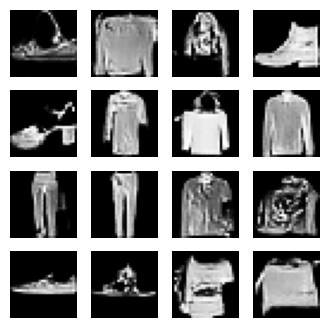

In [15]:
show_images(dc_generator)
